# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [5]:
import tarfile
import os

import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

import wagner_fisher as wf

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

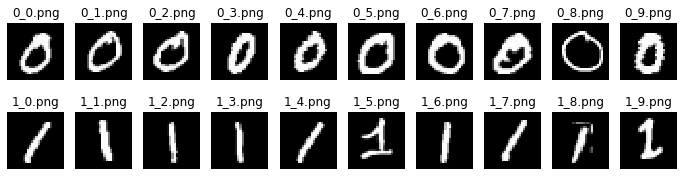

In [6]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])

zeros_im = skimage.io.concatenate_images(ic)
zeros_im = skimage.io.concatenate_images(ic)
zeros_thresholded_tmp = [cv2.threshold(img.copy(), 2, 1, cv2.THRESH_BINARY) for img in zeros_im]
zeros_thresholded = [threshold for _, threshold in zeros_thresholded_tmp]
del zeros_thresholded_tmp

#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))

ones_im = skimage.io.concatenate_images(ic)
ones_thresholded_tmp = [cv2.threshold(img.copy(), 2, 1, cv2.THRESH_BINARY) for img in ones_im]
ones_thresholded = [threshold for _, threshold in ones_thresholded_tmp]
del ones_thresholded_tmp

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [7]:
MIN_CONTOUR_POINT = 20

In [11]:
def find_contour(img, opencv_version):
    """ Finds and returns the contour of the image"""
    contour = []
    if int(opencv_version) >= 3:
        _, contour, _ = cv2.findContours(img, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
        #contour, _ = cv2.findContours(img, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
    else:
        contour, _ = cv2.findContours(img.copy(), mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
    
    contour_array = contour[0].reshape(-1, 2)
    if contour_array.shape[0] < MIN_CONTOUR_POINT:
        contour_array = contour[1].reshape(-1, 2)
    return contour_array

def convert_contour(contour):
    """ separate real and imaginary part of contour values"""
    contour_complex = np.empty(contour.shape[:-1], dtype=complex)
    contour_complex.real = contour[:, 0]
    contour_complex.imag = contour[:, 1]
    return contour_complex

def find_descriptor(contour):
    """ Finds and returns the Fourier-Descriptor from the image contour"""
    return np.fft.fft(contour)

In [12]:
opencv_version, _, _ = cv2.__version__.split(".")

In [13]:
zero_contours = []
one_contours = []

zero_descriptors = []
one_descriptors = []

for zero_img, one_img in zip(zeros_thresholded, ones_thresholded):
    contour0_raw = find_contour(zero_img, opencv_version)
    contour0_complex = convert_contour(contour0_raw)
    descriptor0 = find_descriptor(contour0_complex)

    contour1_raw = find_contour(one_img, opencv_version)
    contour1_complex = convert_contour(contour1_raw)
    descriptor1 = find_descriptor(contour1_complex)
    
    # Save for later usage
    zero_contours.append(contour0_raw)
    one_contours.append(contour1_raw)
    zero_descriptors.append(descriptor0)
    one_descriptors.append(descriptor1)


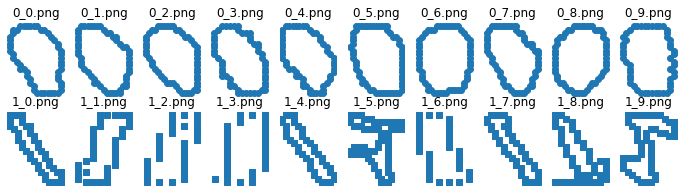

In [14]:
# Plot contours 
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm, cont in zip(axes[0], zeros_im, zeros_names, zero_contours):
    ax.scatter(cont[:, 0], cont[:, 1])
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm, cont in zip(axes[1], ones_im, ones_names, one_contours):
    ax.scatter(cont[:, 0], cont[:, 1], marker=',')
    ax.axis('off')
    ax.set_title(nm)

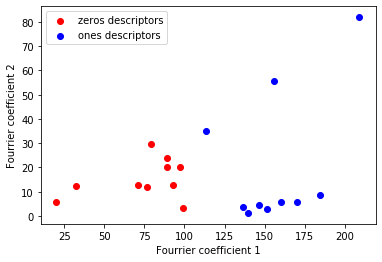

In [15]:
cv2.destroyAllWindows()
nb_coeff = 2
zeros_coeff = []
ones_coeff = []

for zero_descriptor, one_descriptor in zip(zero_descriptors, one_descriptors):
    zeros_coeff.append(np.absolute(zero_descriptor[1:nb_coeff+1]))
    ones_coeff.append(np.absolute(one_descriptor[1:nb_coeff+1]))

plt.scatter(np.asarray(zeros_coeff)[:,0], np.asarray(zeros_coeff)[:,1], color='red', label='zeros descriptors')
plt.scatter(np.asarray(ones_coeff)[:,0], np.asarray(ones_coeff)[:,1], color='blue', label='ones descriptors')   
plt.xlabel("Fourrier coefficient 1")
plt.ylabel("Fourrier coefficient 2")
plt.legend()
plt.show()

### 1.3 Additional method(s)
Add your implementation and discussion

Freeman/Chain method

#### J'ai viré pour l'instant ces parties la :p

#### Display results of distance between freeman codes

In [ ]:
######raise NotImplementedError

## Distance map

In [16]:
def create_distance_map(img):
    """Create distance map from binary image"""
    
    if np.unique(img).shape[0] > 2:
        raise NameError('Binary image expected.')
        
    # Initialization 
    out = np.zeros(img.shape, dtype=np.int64)
    out[img == 0] = 2**62 #infinity
    
    # Direct passage
    for i in range(1, out.shape[0]-1):
        for j in range(1, out.shape[1]-1):
            out[i, j] = np.array([out[i-1, j-1] + 4, out[i-1, j] + 3, out[i-1, j+1] + 4, out[i, j-1] + 3, out[i, j]]).min()
    
    # Inverse passage 
    for i in range(out.shape[0]-2, 0, -1):
        for j in range(out.shape[1]-2, 0, -1):
            out[i, j] = np.array([out[i, j+1] + 3, out[i+1, j-1] + 4, out[i+1, j] + 3, out[i+1, j+1] + 4, out[i, j]]).min()
    
    #!!!!!!! HERE !!!!!!!!
    border = out == 2**62 
    out[border] = 0
    out[border] = out.max()
    return out

## J'ai ajoute : create_distance_map_v2 et compute_dist_v2 selon le code d'Artur

In [17]:
def create_distance_map_v2(img, contour): #contour []x[] and img associated
    """Create distance map from contour"""
    
    if np.unique(img).shape[0] > 2:
        raise NameError('Binary image expected.')
        
    if len(np.shape(contour)) > 2:
        raise NameError('One image contour expected only.')
        
    # Initialization 
    out = np.full(img.shape, np.inf)
    for i in range(len(contour)):
        out[contour[i][0]][contour[i][1]] = 0 
    
    
    # Direct passage
    for i in range(1, out.shape[0]-1):
        for j in range(1, out.shape[1]-1):
            out[i, j] = np.array([out[i-1, j-1] + 4, out[i-1, j] + 3, out[i-1, j+1] + 4, out[i, j-1] + 3, out[i, j]]).min()
    
    # Inverse passage 
    for i in range(out.shape[0]-2, 0, -1):
        for j in range(out.shape[1]-2, 0, -1):
            out[i, j] = np.array([out[i, j+1] + 3, out[i+1, j-1] + 4, out[i+1, j] + 3, out[i+1, j+1] + 4, out[i, j]]).min()

    return out

In [18]:
def compute_dist(img, dist_map):
    """Compute distance between a binary image and another image using its distance map"""
    if np.unique(img).shape[0] > 2:
        raise NameError('Binary image expected.')
    if img.shape != dist_map.shape:
        raise NameError('Images must be of the same size.')
        
    dist = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] != 0:
                dist += dist_map[i,j] 
    return dist

In [19]:
def compute_dist_v2(contour, dist_map):
    """Compute distance between two contours using its distance map"""
    
    if len(np.shape(contour)) > 2:
        raise NameError('One image contour expected only.')
        
    dist = 0    
    for i in range(contour.shape[0]):
        dist += dist_map[contour[i][0],contour[i][1]] 
    
    return dist

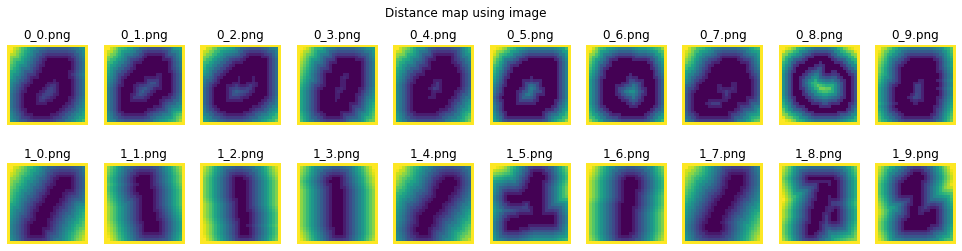

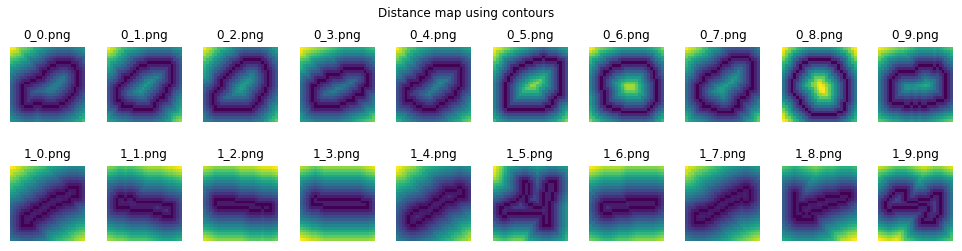

In [20]:
zeros_distance_map = [create_distance_map(img) for img in zeros_thresholded]
ones_distance_map = [create_distance_map(img) for img in ones_thresholded]


zeros_distance_map_v2 = [create_distance_map_v2(img, cnt) for img, cnt in zip(zeros_thresholded, zero_contours)]
ones_distance_map_v2 = [create_distance_map_v2(img, cnt) for img,cnt in zip(ones_thresholded, one_contours)]

fig, axes = plt.subplots(2, len(zeros_distance_map), figsize=(17, 4))
fig.suptitle("Distance map using image")
for ax, im, nm in zip(axes[0], zeros_distance_map, zeros_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_distance_map, ones_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
fig, axes = plt.subplots(2, len(zeros_distance_map_v2), figsize=(17, 4))
fig.suptitle("Distance map using contours")
for ax, im, nm in zip(axes[0], zeros_distance_map_v2, zeros_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_distance_map_v2, ones_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)


In [21]:
# init of the distance map used to class other images
zero_dist_map_ref = zeros_distance_map[0]
one_dist_map_ref = ones_distance_map[0]
zero_dist_map_ref_v2 = zeros_distance_map_v2[0]
one_dist_map_ref_v2 = ones_distance_map_v2[0]

print("V1: Calculating distance for each zero image and associating to its nearest class:")
for i in range(1, len(zeros_distance_map)):
    dist_to_zero = compute_dist(zeros_thresholded[i], zero_dist_map_ref)
    dist_to_one = compute_dist(zeros_thresholded[i], one_dist_map_ref)
    dist_to_zero_v2 = compute_dist_v2(zero_contours[i], zero_dist_map_ref)
    dist_to_one_v2 = compute_dist_v2(zero_contours[i], one_dist_map_ref)
    print('Image {}: Its contour is closer to the contour of image of type {}'.format(zeros_names[i], 0 if dist_to_zero < dist_to_one else 1)) 
    print('-------------> Distance to 0- v1: {} v2: {}, distance to 1- v1: {} v2: {}'.format(dist_to_zero, dist_to_zero_v2, dist_to_one, dist_to_one_v2))
    
print("\nCalculating distance for each zero image and associating to its nearest class:")
for i in range(1, len(zeros_distance_map)):
    dist_to_zero = compute_dist(ones_thresholded[i], zero_dist_map_ref)
    dist_to_one = compute_dist(ones_thresholded[i], one_dist_map_ref)
    dist_to_zero_v2 = compute_dist_v2(one_contours[i], zero_dist_map_ref)
    dist_to_one_v2 = compute_dist_v2(one_contours[i], one_dist_map_ref)
    print('Image {}: Its contour is closer to the contour of image of type {}'.format(ones_names[i], 0 if dist_to_zero < dist_to_one else 1))
    print('-------------> Distance to 0- v1: {} v2: {}, distance to 1- v1: {} v2: {}'.format(dist_to_zero, dist_to_zero_v2, dist_to_one, dist_to_one_v2))


V1: Calculating distance for each zero image and associating to its nearest class:
Image 0_1.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0- v1: 134 v2: 135, distance to 1- v1: 1063 v2: 486
Image 0_2.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0- v1: 179 v2: 126, distance to 1- v1: 1220 v2: 485
Image 0_3.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0- v1: 141 v2: 122, distance to 1- v1: 716 v2: 471
Image 0_4.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0- v1: 161 v2: 121, distance to 1- v1: 909 v2: 470
Image 0_5.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0- v1: 307 v2: 267, distance to 1- v1: 1790 v2: 692
Image 0_6.png: Its contour is closer to the contour of image of type 0
-------------> Distance to 0- v1: 461 v2: 264, distance to 1- v1: 1974 v2: 711
Image 0_7.png: Its 

## Translation part
normalement ca a l'air ok je pense

In [23]:
#contour translation
def contour_translation(contour,trans_x,trans_y):
    translation_vect = [[trans_x],[trans_y]]
    translation_mat = np.repeat(translation_vect,len(contour),axis=1)
    translation_mat = translation_mat.transpose()
    
    #addition
    translated_contours = np.add(contour,translation_mat)
    
    #check if in bounds
    up_limit = 28
    idx = np.where(translated_contours >= up_limit)
    translated_contours = np.delete(translated_contours, idx[0], axis=0)
    low_limit = 0
    idx = np.where(translated_contours < low_limit)
    translated_contours = np.delete(translated_contours, idx[0], axis=0)

    
    return translated_contours

## ISSUE:
dans contour translation, je supprime les coordonnéees des points si ils ne se situent plus dans l'image (28x28)
Du coup quand je calcule mon erreur par rapport a ma distance map (compute_dist_v2), j'ai moins de point a comparer du coup mon erreur est faible. 
Je peux donc pas trouver la translation optimale....

In [ ]:
# optimal translation for the zero images
fig, ax = plt.subplots(1, len(zeros_distance_map_v2), figsize=(12, 3))
ax[0].imshow(zeros_thresholded[0])

for i in range(1, len(zeros_distance_map_v2)):
    dist_to_zero_v2 = 1000
    x_final = 0
    y_final = 0
    [height, width] = zeros_thresholded[i].shape
    print('INIT: image', i )
    for trans_x in range(-5,5,2):        
        for trans_y in range(-5,5,2):
            #translation_matrix = np.float32([[1,0,trans_x], [0,1,trans_y]])
            #img_translation = cv2.warpAffine(zeros_thresholded[i], translation_matrix, (width, height))
            cnt_translation = contour_translation(zero_contours[i],trans_x,trans_y)
            dist2 = compute_dist_v2(cnt_translation, zero_dist_map_ref)
            if dist2 < dist_to_zero_v2:
                dist_to_zero_v2 = dist2
                x_final = trans_x
                y_final = trans_y
                
    translation_matrix = np.float32([[1,0,x_final], [0,1,y_final]])
    img_translation = cv2.warpAffine(zeros_thresholded[i], translation_matrix, (width, height))
    print('Imnage {}: distance min is of value {} for a translation of ({},{}).'.format(i,dist_to_zero_v2,x_final,y_final))
    ax[i].imshow(img_translation)

In [2]:
# optimal translation for the ones images
fig, ax = plt.subplots(1, 2*len(ones_distance_map_v2), figsize=(12, 5))
ax[0].imshow(ones_thresholded[0])

for i in range(1, len(ones_distance_map_v2)):
    dist_to_one_v2 = 1000
    x_final = 0
    y_final = 0
    [height, width] = ones_thresholded[i].shape
    print('INIT: image', i )
    for trans_x in range(-5,5,2):        
        for trans_y in range(-5,5,2):
            cnt_translation = contour_translation(one_contours[i],trans_x,trans_y)
            dist2 = compute_dist_v2(cnt_translation, one_dist_map_ref)
            
            #print(dist2)
            if dist2 < dist_to_one_v2:
                dist_to_one_v2 = dist2
                x_final = trans_x
                y_final = trans_y

    translation_matrix = np.float32([[1,0,x_final], [0,1,y_final]])
    img_translation = cv2.warpAffine(ones_thresholded[i], translation_matrix, (width, height))
    print('Imnage {}: distance min is of value {} for a translation of ({},{}).'.format(i,dist_to_one_v2,x_final,y_final))
    ax[2*i].imshow(ones_thresholded[i])
    ax[2*i+1].imshow(img_translation)

NameError: name 'plt' is not defined

## Rotation part
principalement sur le set des 1, ca marche pas du tout comme il faut..
Je sais pas si c'est le calcul de la distance map, ou le calcul de "l'erreur contour par rapport a la distance map", ou tout simplement ce que j'ai fait below...


In [ ]:
#contour rotation
def contour_rotation(contour,angle,center):

    angle = angle * np.pi / 180 # degrees to radians
    rotated_contours = np.zeros(contour.shape)
    ox, oy = center
    for i in range(contour.shape[0]):       
        px, py = contour[i, :]
        rotated_contours[i,0] = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        rotated_contours[i,1] = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    #check if in bounds
    up_limit = 28
    idx = np.where(rotated_contours >= up_limit)
    rotated_contours = np.delete(rotated_contours, idx[0], axis=0)
    low_limit = 0
    idx = np.where(rotated_contours < low_limit)
    rotated_contours = np.delete(rotated_contours, idx[0], axis=0)
  
    rotated_contours = rotated_contours.astype(int) #they are coordinates need to be int
    return rotated_contours

In [ ]:
# optimal rotation for the zero images
fig, ax = plt.subplots(1, len(zeros_distance_map_v2), figsize=(12, 3))
ax[0].imshow(zeros_thresholded[0])

scale = 1
for i in range(1, len(zeros_distance_map_v2)):
    dist_to_zero_v2 = 1000
    angle_final = 0
    [height, width] = zeros_thresholded[i].shape
    center = (width / 2, height / 2)
    print('INIT: image', i )
    
    for angle in np.arange(0, 360, 15):  
        #rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        #img_rotation = cv2.warpAffine(zeros_thresholded[i], rotation_matrix, (width, height))
        cnt_rotation = contour_rotation(zero_contours[i],angle,center)
        dist2 = compute_dist_v2(cnt_rotation, zero_dist_map_ref)
        if dist2 < dist_to_zero_v2:
            dist_to_zero_v2 = dist2
            angle_final = angle
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_final, scale)    
    img_rotation = cv2.warpAffine(zeros_thresholded[i], rotation_matrix, (width, height))
    print('Imnage {}: distance min is of value {} for a rotation of {} degrees.'.format(i,dist_to_zero_v2,angle_final))
    ax[i].imshow(img_rotation)
    


In [1]:
# optimal rotation for the one images
fig, ax = plt.subplots(2, len(ones_distance_map_v2)+1, figsize=(17, 4))
ax[0][0].imshow(ones_thresholded[0])

scale = 1
for i in range(len(ones_distance_map_v2)):
    dist_to_one_v2 = 1000
    dist_to_one = 1000
    angle_final = 0
    [height, width] = ones_thresholded[i].shape
    center = (width / 2, height / 2)
    print('INIT: image', i )
    
    for angle in np.arange(0, 360, 2):  
        cnt_rotation = contour_rotation(one_contours[i],angle,center)
        dist2 = compute_dist_v2(cnt_rotation, one_dist_map_ref)
        if dist2 < dist_to_one_v2:
            dist_to_one_v2 = dist2
            angle_final = angle
       
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_final, scale)    
    img_rotation = cv2.warpAffine(ones_thresholded[i], rotation_matrix, (width, height))
    print('Image {}: distance min is of value {} for a rotation of {} degrees.'.format(i,dist_to_one_v2,angle_final))
    ax[0][i+1].imshow(img_rotation)
    ax[1][i+1].imshow(ones_thresholded[i])
    


    


NameError: name 'plt' is not defined

## Translation et rotation ensemble..
guess what ca marche pas ahhahaa

In [ ]:
# optimal TRANSLATION/rotation for the zero images
fig, ax = plt.subplots(1, len(zeros_distance_map_v2), figsize=(12, 3))
ax[0].imshow(zeros_thresholded[0])

scale = 1
for i in range(1, len(zeros_distance_map_v2)):
    dist_to_zero_v2 = 1000
    angle_final = 0
    x_final = 0
    y_final = 0
    [height, width] = zeros_thresholded[i].shape
    center = (width / 2, height / 2)
    print('INIT: image', i )
    for trans_x in range(-5,5,1):        
        for trans_y in range(-5,5,1):
            for angle in np.arange(0, 360, 10):  
                translation_matrix = np.float32([[1,0,trans_x], [0,1,trans_y]])
                img_translation = cv2.warpAffine(zeros_thresholded[i], translation_matrix, (width, height))
                cnt_translation = contour_translation(zero_contours[i],trans_x,trans_y)
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
                img_rotation = cv2.warpAffine(img_translation, rotation_matrix, (width, height))
                cnt_rotation = contour_rotation(cnt_translation,angle,center)
                dist2 = compute_dist_v2(img_rotation, cnt_rotation, zero_dist_map_ref)
                if dist2 < dist_to_zero_v2:
                    dist_to_zero_v2 = dist2
                    angle_final = angle
                    x_final = trans_x
                    y_final = trans_y
    
    translation_matrix = np.float32([[1,0,x_final], [0,1,y_final]])
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_final, scale)
    img_translation = cv2.warpAffine(zeros_thresholded[i], translation_matrix, (width, height))
    img_rotation = cv2.warpAffine(img_translation, rotation_matrix, (width, height))
    print('Imnage {}: distance min is of value {} for a rotation of {} degrees.'.format(i,dist_to_zero_v2,angle_final))
    ax[i].imshow(img_rotation)
    


In [ ]:
# optimal TRANSLATION/rotation for the zero images
fig, ax = plt.subplots(1, len(ones_distance_map_v2), figsize=(12, 3))
ax[0].imshow(ones_thresholded[0])

scale = 1
for i in range(1, len(ones_distance_map_v2)):
    dist_to_one_v2 = 1000
    angle_final = 0
    x_final = 0
    y_final = 0
    [height, width] = ones_thresholded[i].shape
    center = (width / 2, height / 2)
    print('INIT: image', i )
    for trans_x in range(-5,5,1):        
        for trans_y in range(-5,5,1):
            for angle in np.arange(0, 360, 10):  
                cnt_translation = contour_translation(one_contours[i],trans_x,trans_y)
                cnt_rotation = contour_rotation(cnt_translation,angle,center)
                dist2 = compute_dist_v2(cnt_rotation, one_dist_map_ref)
                if dist2 < dist_to_one_v2:
                    dist_to_one_v2 = dist2
                    angle_final = angle
                    x_final = trans_x
                    y_final = trans_y
    
    translation_matrix = np.float32([[1,0,x_final], [0,1,y_final]])
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_final, scale)
    img_translation = cv2.warpAffine(ones_thresholded[i], translation_matrix, (width, height))
    img_rotation = cv2.warpAffine(img_translation, rotation_matrix, (width, height))
    print('Imnage {}: distance min is of value {} for a rotation of {} degrees.'.format(i,dist_to_one_v2,angle_final))
    ax[i].imshow(img_rotation)
    



## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

In [ ]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here